In [33]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import rasterio
import numpy as np
import pandas as pd
from dbfread import DBF

class mla():
    
    'Supervised and unsupervised classification in Remote Sensing'
    
    def __init__(self, image, endm):
        
        self.image = image
        self.endm = endm
        
        if not isinstance(self.image, (rasterio.io.DatasetReader)):
            raise TypeError('"image" must be raster read by rasterio.open().')
        
        bands = self.image.count
        
        rows = self.image.height
        
        cols = self.image.width
        
        st = image.read()
        
        # data in [rows, cols, bands]
        st_reorder = np.moveaxis(st, 0, -1) 
        # data in [rows*cols, bands]
        arr = st_reorder.reshape(rows*cols, bands)

        # if it is read by pandas.read_csv()
        if isinstance(self.endm, (pd.core.frame.DataFrame)):
            
            for i in np.arange(self.endm.shape[1]):
                
                if all(self.endm.iloc[:,int(i)] < 100) & all(self.endm.iloc[:,int(i)] >= 1): indx = i; break
        
        # if the file is .dbf    
        elif isinstance(self.endm, (DBF)): # isinstance() function With Inheritance
            
            self.endm = pd.DataFrame(iter(self.endm))
            
            for i in np.arange(self.endm.shape[1]):
                
                if all(self.endm.iloc[:,int(i)] < 100) & all(self.endm.iloc[:,int(i)] >= 1): indx = i; break
        
        else:
            raise TypeError('"endm" must be .csv (pandas.core.frame.DataFrame).')

        if not self.endm.shape[1] == (bands + 1):
            raise ValueError('The number of columns of signatures (included the class column) must'
                             'be equal to the number of bands + 1.')
        
        self.indx = indx
        
        self.arr = arr
        
        self.rows = rows
        
        self.cols = cols
        
    def SVM(self, training_split = 0.8, kernel = 'linear', **kwargs):
        
        '''The Support Vector Machine (SVM) classifier is a supervised non-parametric statistical learning technique that 
        does not assume a preliminary distribution of input data. Its discrimination criterion is a 
        hyperplane that separates the classes in the multidimensional space in which the samples 
        that have established the same classes are located, generally some training areas.
        
        SVM support raster data read by rasterio (rasterio.io.DatasetReader) as input.
        
        
        Parameters:
    
            training_split: For splitting samples into two subsets, i.e. training data and for testing
                            data.
    
            kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf' Specifies 
                     the kernel type to be used in the algorithm. It must be one of 'linear', 'poly', 
                     'rbf', 'sigmoid', 'precomputed' or a callable. If None is given, 'rbf' will 
                     be used. See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
                     for more details.
                     
            **kwargs: These will be passed to SVM, please see full lists at:
                  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    
        Return:
        
            Labels of classification as numpy object.
        '''
        
        # removing the class column
        X = self.endm.drop(self.endm.columns[[self.indx]], axis = 1)
        
        # only predictor variables
        y = self.endm.iloc[:, self.indx]
        
        # split in training and testing
        Xtrain, Xtest, ytrain, ytest = train_test_split(
            X, 
            y, 
            train_size = training_split, 
            test_size = 1 - training_split, 
            random_state = 0)
        
        # applying a support vector machine
        inst_svm = SVC(kernel = kernel, **kwargs)
        
        # model trained
        mt_svm = inst_svm.fit(Xtrain, ytrain)
        
        labels_svm = mt_svm.predict(self.arr)
        classSVM = labels_svm.reshape((self.rows, self.cols))
        
        # Confusion matrix
        predic_Xtest = mt_svm.predict(Xtest)
        
        MC = confusion_matrix(ytest, predic_Xtest)
    
        MC = np.transpose(MC)

        # Users Accuracy and Commission
        total_rows = np.sum(MC, axis = 1)
        ua = np.diag(MC)/np.sum(MC, axis = 1)*100
        co = 100 - ua

        # Producer Accuracy and Comission
        total_cols = np.sum(MC, axis = 0)
        pa = np.diag(MC)/np.sum(MC, axis = 0)*100
        om = 100 - pa

        total_cols = np.concatenate([total_cols, np.repeat(np.nan, 3)])
        pa = np.concatenate([pa, np.repeat(np.nan, 3)])
        om = np.concatenate([om, np.repeat(np.nan, 3)])

        n = MC.shape[0]
        cm = np.concatenate([MC, total_rows.reshape((n,1)), ua.reshape((n,1)), 
                             co.reshape((n,1))], axis = 1)
        cm = np.concatenate([cm, total_cols.reshape((1,n+3)), pa.reshape((1,n+3)), 
                             om.reshape((1,n+3))])

        namesCol = []
        for i in np.arange(0, n):
            stri = str(i)
            namesCol.append(stri)

        namesCol.extend(['Total', 'Users_Accuracy', 'Commission'])

        namesRow = []
        for i in np.arange(0, n):
            stri = str(i)
            namesRow.append(stri)

        namesRow.extend(['Total', 'Producer_Accuracy', 'Omission'])
        namesRow

        confusionMatrix = pd.DataFrame(cm, 
                                        columns = namesCol, 
                                        index = namesRow)

        oa = accuracy_score(ytest, predic_Xtest)
        kappa = cohen_kappa_score(ytest, predic_Xtest)
        
        output = {'Overall_Accuracy': oa,
                  'Kappa_Index': kappa,
                  'Confusion_Matrix': confusionMatrix,
                  'Classification_Map': classSVM
                 } 
    
        return output
    
    def DT(self, training_split = 0.8, **kwargs):
        
        '''The Support Vector Machine (SVM) classifier is a supervised non-parametric statistical learning technique that 
        does not assume a preliminary distribution of input data. Its discrimination criterion is a 
        hyperplane that separates the classes in the multidimensional space in which the samples 
        that have established the same classes are located, generally some training areas.
        
        SVM support raster data read by rasterio (rasterio.io.DatasetReader) as input.
        
        
        Parameters:
    
            training_split: For splitting samples into two subsets, i.e. training data and for testing
                            data.
    
            kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf' Specifies 
                     the kernel type to be used in the algorithm. It must be one of 'linear', 'poly', 
                     'rbf', 'sigmoid', 'precomputed' or a callable. If None is given, 'rbf' will 
                     be used. See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
                     for more details.
                     
            **kwargs: These will be passed to SVM, please see full lists at:
                  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    
        Return:
        
            Labels of classification as numpy object.
        '''
        
        # removing the class column
        X = self.endm.drop(self.endm.columns[[self.indx]], axis = 1)
        
        # only predictor variables
        y = self.endm.iloc[:, self.indx]
        
        # split in training and testing
        Xtrain, Xtest, ytrain, ytest = train_test_split(
            X, 
            y, 
            train_size = training_split, 
            test_size = 1 - training_split, 
            random_state = 0)
        
        # applying a support vector machine
        inst_dt = DT(**kwargs)
        
        # model trained
        mt_dt = inst_dt.fit(Xtrain, ytrain)
        
        labels_dt = mt_dt.predict(self.arr)
        classDT = labels_dt.reshape((self.rows, self.cols))
        
        # Confusion matrix
        predic_Xtest = mt_dt.predict(Xtest)
        
        MC = confusion_matrix(ytest, predic_Xtest)
    
        MC = np.transpose(MC)

        # Users Accuracy and Commission
        total_rows = np.sum(MC, axis = 1)
        ua = np.diag(MC)/np.sum(MC, axis = 1)*100
        co = 100 - ua

        # Producer Accuracy and Comission
        total_cols = np.sum(MC, axis = 0)
        pa = np.diag(MC)/np.sum(MC, axis = 0)*100
        om = 100 - pa

        total_cols = np.concatenate([total_cols, np.repeat(np.nan, 3)])
        pa = np.concatenate([pa, np.repeat(np.nan, 3)])
        om = np.concatenate([om, np.repeat(np.nan, 3)])

        n = MC.shape[0]
        cm = np.concatenate([MC, total_rows.reshape((n,1)), ua.reshape((n,1)), 
                             co.reshape((n,1))], axis = 1)
        cm = np.concatenate([cm, total_cols.reshape((1,n+3)), pa.reshape((1,n+3)), 
                             om.reshape((1,n+3))])

        namesCol = []
        for i in np.arange(0, n):
            stri = str(i)
            namesCol.append(stri)

        namesCol.extend(['Total', 'Users_Accuracy', 'Commission'])

        namesRow = []
        for i in np.arange(0, n):
            stri = str(i)
            namesRow.append(stri)

        namesRow.extend(['Total', 'Producer_Accuracy', 'Omission'])
        namesRow

        confusionMatrix = pd.DataFrame(cm, 
                                        columns = namesCol, 
                                        index = namesRow)

        oa = accuracy_score(ytest, predic_Xtest)
        kappa = cohen_kappa_score(ytest, predic_Xtest)
        
        output = {'Overall_Accuracy': oa,
                  'Kappa_Index': kappa,
                  'Confusion_Matrix': confusionMatrix,
                  'Classification_Map': classDT
                 } 
    
        return output
    
    def RF(self, training_split = 0.8, **kwargs):
        
        '''The Support Vector Machine (SVM) classifier is a supervised non-parametric statistical learning technique that 
        does not assume a preliminary distribution of input data. Its discrimination criterion is a 
        hyperplane that separates the classes in the multidimensional space in which the samples 
        that have established the same classes are located, generally some training areas.
        
        SVM support raster data read by rasterio (rasterio.io.DatasetReader) as input.
        
        
        Parameters:
    
            training_split: For splitting samples into two subsets, i.e. training data and for testing
                            data.
    
            kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf' Specifies 
                     the kernel type to be used in the algorithm. It must be one of 'linear', 'poly', 
                     'rbf', 'sigmoid', 'precomputed' or a callable. If None is given, 'rbf' will 
                     be used. See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
                     for more details.
                     
            **kwargs: These will be passed to SVM, please see full lists at:
                  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    
        Return:
        
            Labels of classification as numpy object.
        '''
        
        # removing the class column
        X = self.endm.drop(self.endm.columns[[self.indx]], axis = 1)
        
        # only predictor variables
        y = self.endm.iloc[:, self.indx]
        
        # split in training and testing
        Xtrain, Xtest, ytrain, ytest = train_test_split(
            X, 
            y, 
            train_size = training_split, 
            test_size = 1 - training_split, 
            random_state = 0)
        
        # applying a support vector machine
        inst_rf = RF(**kwargs)
        
        # model trained
        mt_rf = inst_rf.fit(Xtrain, ytrain)
        
        labels_rf = mt_rf.predict(self.arr)
        classRF = labels_rf.reshape((self.rows, self.cols))
        
        # Confusion matrix
        predic_Xtest = mt_rf.predict(Xtest)
        
        MC = confusion_matrix(ytest, predic_Xtest)
    
        MC = np.transpose(MC)

        # Users Accuracy and Commission
        total_rows = np.sum(MC, axis = 1)
        ua = np.diag(MC)/np.sum(MC, axis = 1)*100
        co = 100 - ua

        # Producer Accuracy and Comission
        total_cols = np.sum(MC, axis = 0)
        pa = np.diag(MC)/np.sum(MC, axis = 0)*100
        om = 100 - pa

        total_cols = np.concatenate([total_cols, np.repeat(np.nan, 3)])
        pa = np.concatenate([pa, np.repeat(np.nan, 3)])
        om = np.concatenate([om, np.repeat(np.nan, 3)])

        n = MC.shape[0]
        cm = np.concatenate([MC, total_rows.reshape((n,1)), ua.reshape((n,1)), 
                             co.reshape((n,1))], axis = 1)
        cm = np.concatenate([cm, total_cols.reshape((1,n+3)), pa.reshape((1,n+3)), 
                             om.reshape((1,n+3))])

        namesCol = []
        for i in np.arange(0, n):
            stri = str(i)
            namesCol.append(stri)

        namesCol.extend(['Total', 'Users_Accuracy', 'Commission'])

        namesRow = []
        for i in np.arange(0, n):
            stri = str(i)
            namesRow.append(stri)

        namesRow.extend(['Total', 'Producer_Accuracy', 'Omission'])
        namesRow

        confusionMatrix = pd.DataFrame(cm, 
                                        columns = namesCol, 
                                        index = namesRow)

        oa = accuracy_score(ytest, predic_Xtest)
        kappa = cohen_kappa_score(ytest, predic_Xtest)
        
        output = {'Overall_Accuracy': oa,
                  'Kappa_Index': kappa,
                  'Confusion_Matrix': confusionMatrix,
                  'Classification_Map': classRF
                 } 
    
        return output
    
    def NB(self, training_split = 0.8, **kwargs):
        
        '''The Support Vector Machine (SVM) classifier is a supervised non-parametric statistical learning technique that 
        does not assume a preliminary distribution of input data. Its discrimination criterion is a 
        hyperplane that separates the classes in the multidimensional space in which the samples 
        that have established the same classes are located, generally some training areas.
        
        SVM support raster data read by rasterio (rasterio.io.DatasetReader) as input.
        
        
        Parameters:
    
            training_split: For splitting samples into two subsets, i.e. training data and for testing
                            data.
    
            kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf' Specifies 
                     the kernel type to be used in the algorithm. It must be one of 'linear', 'poly', 
                     'rbf', 'sigmoid', 'precomputed' or a callable. If None is given, 'rbf' will 
                     be used. See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
                     for more details.
                     
            **kwargs: These will be passed to SVM, please see full lists at:
                  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    
        Return:
        
            Labels of classification as numpy object.
        '''
        
        # removing the class column
        X = self.endm.drop(self.endm.columns[[self.indx]], axis = 1)
        
        # only predictor variables
        y = self.endm.iloc[:, self.indx]
        
        # split in training and testing
        Xtrain, Xtest, ytrain, ytest = train_test_split(
            X, 
            y, 
            train_size = training_split, 
            test_size = 1 - training_split, 
            random_state = 0)
        
        # applying a support vector machine
        inst_nb = GNB(**kwargs)
        
        # model trained
        mt_nb = inst_nb.fit(Xtrain, ytrain)
        
        labels_nb = mt_nb.predict(self.arr)
        classNB = labels_nb.reshape((self.rows, self.cols))
        
        # Confusion matrix
        predic_Xtest = mt_nb.predict(Xtest)
        
        MC = confusion_matrix(ytest, predic_Xtest)
    
        MC = np.transpose(MC)

        # Users Accuracy and Commission
        total_rows = np.sum(MC, axis = 1)
        ua = np.diag(MC)/np.sum(MC, axis = 1)*100
        co = 100 - ua

        # Producer Accuracy and Comission
        total_cols = np.sum(MC, axis = 0)
        pa = np.diag(MC)/np.sum(MC, axis = 0)*100
        om = 100 - pa

        total_cols = np.concatenate([total_cols, np.repeat(np.nan, 3)])
        pa = np.concatenate([pa, np.repeat(np.nan, 3)])
        om = np.concatenate([om, np.repeat(np.nan, 3)])

        n = MC.shape[0]
        cm = np.concatenate([MC, total_rows.reshape((n,1)), ua.reshape((n,1)), 
                             co.reshape((n,1))], axis = 1)
        cm = np.concatenate([cm, total_cols.reshape((1,n+3)), pa.reshape((1,n+3)), 
                             om.reshape((1,n+3))])

        namesCol = []
        for i in np.arange(0, n):
            stri = str(i)
            namesCol.append(stri)

        namesCol.extend(['Total', 'Users_Accuracy', 'Commission'])

        namesRow = []
        for i in np.arange(0, n):
            stri = str(i)
            namesRow.append(stri)

        namesRow.extend(['Total', 'Producer_Accuracy', 'Omission'])
        namesRow

        confusionMatrix = pd.DataFrame(cm, 
                                        columns = namesCol, 
                                        index = namesRow)

        oa = accuracy_score(ytest, predic_Xtest)
        kappa = cohen_kappa_score(ytest, predic_Xtest)
        
        output = {'Overall_Accuracy': oa,
                  'Kappa_Index': kappa,
                  'Confusion_Matrix': confusionMatrix,
                  'Classification_Map': classNB
                 } 
    
        return output
    
    def NN(self, training_split = 0.8, max_iter = 300, **kwargs):
        
        '''The Support Vector Machine (SVM) classifier is a supervised non-parametric statistical learning technique that 
        does not assume a preliminary distribution of input data. Its discrimination criterion is a 
        hyperplane that separates the classes in the multidimensional space in which the samples 
        that have established the same classes are located, generally some training areas.
        
        SVM support raster data read by rasterio (rasterio.io.DatasetReader) as input.
        
        
        Parameters:
    
            training_split: For splitting samples into two subsets, i.e. training data and for testing
                            data.
    
            kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf' Specifies 
                     the kernel type to be used in the algorithm. It must be one of 'linear', 'poly', 
                     'rbf', 'sigmoid', 'precomputed' or a callable. If None is given, 'rbf' will 
                     be used. See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
                     for more details.
                     
            **kwargs: These will be passed to SVM, please see full lists at:
                  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    
        Return:
        
            Labels of classification as numpy object.
        '''
        
        # removing the class column
        X = self.endm.drop(self.endm.columns[[self.indx]], axis = 1)
        
        # only predictor variables
        y = self.endm.iloc[:, self.indx]
        
        # split in training and testing
        Xtrain, Xtest, ytrain, ytest = train_test_split(
            X, 
            y, 
            train_size = training_split, 
            test_size = 1 - training_split, 
            random_state = 0)
        
        # applying a support vector machine
        inst_nn = MLP(max_inter = max_iter, **kwargs)
        
        # model trained
        mt_nn = inst_nn.fit(Xtrain, ytrain)
        
        labels_nn = mt_nn.predict(self.arr)
        classNN = labels_nn.reshape((self.rows, self.cols))
        
        # Confusion matrix
        predic_Xtest = mt_nn.predict(Xtest)
        
        MC = confusion_matrix(ytest, predic_Xtest)
    
        MC = np.transpose(MC)

        # Users Accuracy and Commission
        total_rows = np.sum(MC, axis = 1)
        ua = np.diag(MC)/np.sum(MC, axis = 1)*100
        co = 100 - ua

        # Producer Accuracy and Comission
        total_cols = np.sum(MC, axis = 0)
        pa = np.diag(MC)/np.sum(MC, axis = 0)*100
        om = 100 - pa

        total_cols = np.concatenate([total_cols, np.repeat(np.nan, 3)])
        pa = np.concatenate([pa, np.repeat(np.nan, 3)])
        om = np.concatenate([om, np.repeat(np.nan, 3)])

        n = MC.shape[0]
        cm = np.concatenate([MC, total_rows.reshape((n,1)), ua.reshape((n,1)), 
                             co.reshape((n,1))], axis = 1)
        cm = np.concatenate([cm, total_cols.reshape((1,n+3)), pa.reshape((1,n+3)), 
                             om.reshape((1,n+3))])

        namesCol = []
        for i in np.arange(0, n):
            stri = str(i)
            namesCol.append(stri)

        namesCol.extend(['Total', 'Users_Accuracy', 'Commission'])

        namesRow = []
        for i in np.arange(0, n):
            stri = str(i)
            namesRow.append(stri)

        namesRow.extend(['Total', 'Producer_Accuracy', 'Omission'])
        namesRow

        confusionMatrix = pd.DataFrame(cm, 
                                        columns = namesCol, 
                                        index = namesRow)

        oa = accuracy_score(ytest, predic_Xtest)
        kappa = cohen_kappa_score(ytest, predic_Xtest)
        
        output = {'Overall_Accuracy': oa,
                  'Kappa_Index': kappa,
                  'Confusion_Matrix': confusionMatrix,
                  'Classification_Map': classNN
                 } 
    
        return output

In [3]:
import matplotlib.pyplot as plt
from dbfread import DBF
import rasterio

path_raster = r"G:\4_RS_Python\Leccion4\Datos\232066\LC08_SUBSET_232066_20190727_STACK.tif"
img = rasterio.open(path_raster)

path_endmembers = r"G:\4_RS_Python\Leccion4\shp\signaturas2018.dbf"
endmembers = DBF(path_endmembers)
frame = pd.DataFrame(iter(endmembers))

clas = mla(image = img, endm = endmembers)
classi = clas.NN(training_split = 0.5)
classi.get('Confusion_Matrix')

NameError: name 'pd' is not defined

In [13]:
from sklearn.cluster import KMeans
import rasterio
import numpy as np

def rkmeans(image, **kwargs):
    
    '''The Support Vector Machine (SVM) classifier is a supervised non-parametric statistical learning technique that 
        does not assume a preliminary distribution of input data. Its discrimination criterion is a 
        hyperplane that separates the classes in the multidimensional space in which the samples 
        that have established the same classes are located, generally some training areas.
        
        SVM support raster data read by rasterio (rasterio.io.DatasetReader) as input.
        
        
        Parameters:
            
            image: Optical images. It must be numpy.ndarray with 3d.
    
            training_split: For splitting samples into two subsets, i.e. training data and for testing
                            data.
    
            kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf' Specifies 
                     the kernel type to be used in the algorithm. It must be one of 'linear', 'poly', 
                     'rbf', 'sigmoid', 'precomputed' or a callable. If None is given, 'rbf' will 
                     be used. See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
                     for more details.
                     
            **kwargs: These will be passed to SVM, please see full lists at:
                  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    
        Return:
        
            Labels of classification as numpy object.
    '''
    
    if not isinstance(image, (rasterio.io.DatasetReader)):
        raise TypeError('"image" must be raster read by rasterio.open().')
        
    bands = image.count
        
    rows = image.height
        
    cols = image.width
        
    # stack images
    #l = []
    #for i in np.arange(1, bands+1): l.append(image.read(int(i)))
    #st = np.stack(l)
    st = image.read()
    
    # data in [rows, cols, bands]
    st_reorder = np.moveaxis(st, 0, -1) 
    # data in [rows*cols, bands]
    arr = st_reorder.reshape(rows*cols, bands)
    
    kmeans = KMeans(**kwargs) # max_iter=300 (por defecto)
    kmeans.fit(arr)
    
    labels_km = kmeans.labels_
    classKM = labels_km.reshape((rows, cols))
    
    return classKM
        

In [14]:
import matplotlib.pyplot as plt
from dbfread import DBF
import rasterio

path_raster = r"G:\4_RS_Python\Leccion4\Datos\232066\LC08_SUBSET_232066_20190727_STACK.tif"
img = rasterio.open(path_raster)

img.read().shape
clas = rkmeans(image = img, n_clusters = 4)

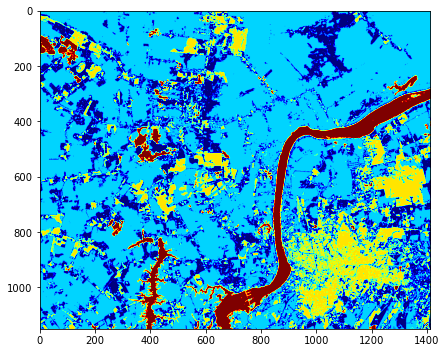

In [16]:
# kmeans
plt.figure(figsize=(7,7))
plt.imshow(clas, cmap = 'jet')
plt.show()

In [36]:
import rasterio
import numpy as np

def sma(image, endmembers):
    '''
    The SMA assumes that the energy received within the field of vision of the remote sensor 
    can be considered as the sum of the energies received from each dominant endmember. 
    This function addresses a Linear Mixing Model.
    
    A regression analysis is used to obtain the fractions. In least squares inversion algorithms, 
    the common objective is to estimate abundances that minimize the squared error between the 
    actual spectrum and the estimated spectrum. The values of the fractions will be between 0 and 1.
    
    Parameters:
    
        image: Optical images. It must be numpy.ndarray with 3d.
        
        endmembers: Endmembers must be a matrix (numpy.ndarray) and with more than one endmember. 
                    Rows represent the endmembers and columns represent the spectral bands.
                    The number of bands must be greater than the number of endmembers.
                    E.g. an image with 6 bands, endmembers dimension should be $n*6$, where $n$ 
                    is rows with the number of endmembers and 6 is the number of bands 
                    (should be equal).
    
    Return:
        numpy.ndarray with 2d.
    '''
    
    if not isinstance(image, (rasterio.io.DatasetReader)):
        raise TypeError('"image" must be raster read by rasterio.open().')
        
    if not isinstance (endmembers, (np.ndarray)):
        raise ErrorType('"endmembers" must be numpy.ndarray.')
    
    bands = image.count
        
    rows = image.height
        
    cols = image.width
    
    # number of endmembers
    n_endm = endmembers.shape[0]
    
    # number of bands extracted for each endmember
    b_endm = endmembers.shape[1]
        
    st = image.read()
        
    # data in [rows, cols, bands]
    st_reorder = np.moveaxis(st, 0, -1) 
    # data in [rows*cols, bands]
    arr = st_reorder.reshape((rows*cols, bands))
    
    if not arr.shape[1] > n_endm:
        raise ValueError('The number of bands must be greater than the number of endmembers.')
    
    if not arr.shape[1] == b_endm:
        raise ValueError('The number of values extracted in band should be equal.')
    
    M = np.transpose(endmembers)
    
    mat_oper = np.dot(np.linalg.inv(np.dot(np.transpose(M), M)), np.transpose(M)) 
    
    frac = np.zeros((rows*cols, n_endm))
                
    for i in np.arange(0, n_endm, 1):
        for j in np.arange(0, rows*cols, 1):
            f = np.dot(mat_oper, arr[j,:])
            frac[j,i] = f[i,]
    
    sma_img = frac.reshape((rows, cols, n_endm))
    
    return sma_img

In [39]:
# La ruta de la imagen
path_img = "G:/4_RS_Python/Leccion5/Datos/232066/LC08_SUBSET_232066_20190727_STACK.tif"
# Luego procedemos a leerla con la funcion gdal.Open()
img = rasterio.open(path_img)

# Firmas espectrales puras
M =np.array([[8980,8508,8704,13636,16579,11420], # suelo
    [8207,7545,6548,16463,9725,6673], # bosque
    [9276,9570,10089,6743,5220,5143], # agua
    ])
#sma = sma(image = img, endmembers = M)
img.shape

(1150, 1412)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


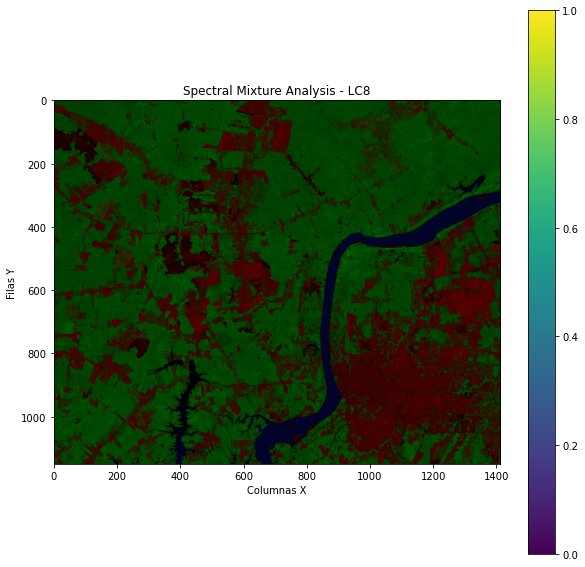

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(sma) # magma, gray, etc.
plt.colorbar()
plt.title("Spectral Mixture Analysis - LC8") # Titulo
plt.xlabel('Columnas X') # Nombre del eje X
plt.ylabel('Filas Y') # Nombre del eje Y
plt.show()

In [33]:
import numpy as np

def tassCap(image, sat = "Landsat8OLI"):
    
    '''
    The Tasseled-Cap Transformation is a linear transformation method for various 
    remote sensing data. Not only can it perform volume data compression, but it
    can also provide parameters associated with the physical characteristics, 
    such as brightness, greenness and wetness indices.
    
    Parameters:
    
        image: Optical images. It must be numpy.ndarray with 3d.
        
        endmembers: Specify satellite and sensor type (Landsat5TM, Landsat7ETM or Landsat8OLI).
                    See the list of satellites below.
    
    Return:
        numpy.ndarray with 2d.
    
    
    References:
    - Crist, E.P., R. Laurin, and R.C. Cicone. 1986. Vegetation and soils information 
      contained in transformed Thematic Mapper data. Pages 1465-1470 Ref. ESA SP-254. 
      European Space Agency, Paris, France. http://www.ciesin.org/docs/005-419/005-419.html.
    
    - Baig, M.H.A., Shuai, T., Tong, Q., 2014. Derivation of a tasseled cap transformation 
      based on Landsat 8 at-satellite reflectance. Remote Sensing Letters, 5(5), 423-431. 
    
    - Li, B., Ti, C., Zhao, Y., Yan, X., 2016. Estimating Soil Moisture with Landsat Data 
      and Its Application in Extracting the Spatial Distribution of Winter Flooded Paddies. 
      Remote Sensing, 8(1), 38.
    
    Note:
    Currently implemented for satellites such as Landsat-4 TM, Landsat-5 TM, Landsat-7 ETM+, 
    Landsat-8 OLI and Sentinel2. The input data must be in top of atmosphere reflectance (toa). 
    Bands required as input must be ordered as:
    
    Consider using the following satellite bands:
    ===============   ================================
    Type of Sensor     Name of bands
    ===============   ================================
    Landsat4TM         :blue, green, red, nir, swir1, swir2
    Landsat5TM         :blue, green, red, nir, swir1, swir2
    Landsat7ETM+       :blue, green, red, nir, swir1, swir2
    Landsat8OLI        :blue, green, red, nir, swir1, swir2
    Landsat8OLI-Li2016 :coastal, blue, green, red, nir, swir1, swir2
    Sentinel2MSI       :coastal, blue, green, red, nir-1, mir-1, mir-2
    
    '''
    
    if not isinstance(image, (rasterio.io.DatasetReader)):
        raise TypeError('"image" must be raster read by rasterio.open().')
        
    if sat == 'Landsat4TM':
        coefc = np.array([[0.3037, 0.2793, 0.4743, 0.5585, 0.5082, 0.1863], # brightness
                         [-0.2848, -0.2435, -0.5436, 0.7243, 0.0840, -0.1800], # greenness
                         [0.1509, 0.1973, 0.3279, 0.3406, -0.7112, -0.4572]]) # wetness
    
    elif sat == 'Landsat5TM':
        coefc = np.array([[0.2909, 0.2493, 0.4806, 0.5568, 0.4438, 0.1706],
                         [-0.2728, -0.2174, -0.5508, 0.7221, 0.0733, -0.1648],
                         [0.1446, 0.1761, 0.3322, 0.3396, -0.6210, -0.4186]])
    
    elif sat == 'Landsat7ETM':
        coefc = np.array([[0.3561, 0.3972, 0.3904, 0.6966, 0.2286, 0.1596],
                         [-0.3344, -0.3544, -0.4556, 0.6966, -0.0242, -0.2630],
                         [0.2626, 0.2141, 0.0926, 0.0656, -0.7629, 0.5388]])
    
    elif sat == 'Landsat8OLI':
        coefc = np.array([[0.3029, 0.2786, 0.4733, 0.5599, 0.5080, 0.1872],
                         [-0.2941, -0.2430, -0.5424, 0.7276, 0.0713, -0.1608],
                         [0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559]])
    
    elif sat == 'Landsat8OLI-Li2016':
        coefc = np.array([[0.2540, 0.3037, 0.3608, 0.3564, 0.7084, 0.2358, 0.1691],
                         [-0.2578, -0.3064, -0.3300, -0.4325, 0.6860, -0.0383, -0.2674],
                         [0.1877, 0.2097, 0.2038, 0.1017, 0.0685, -0.7460, -0.5548]])
        
    elif sat == 'Sentinel2MSI':
        coefc = np.array([[0.2381, 0.2569, 0.2934, 0.3020, 0.3580, 0.0896, 0.0780],
                         [-0.2266, -0.2818, -0.3020, -0.4283, 0.3138, -0.1341, -0.2538],
                         [0.1825, 0.1763, 0.1615, 0.0486, -0.0755, -0.7701, -0.5293]])
    else:
        raise ValueError('Satellite not supported. Please see the list of satellites mentioned'
                         'in docstrings.')
    
    bands = image.count
        
    rows = image.height
        
    cols = image.width
        
    st = image.read()
        
    # data in [rows, cols, bands]
    st_reorder = np.moveaxis(st, 0, -1) 
    # data in [rows*cols, bands]
    arr = st_reorder.reshape((rows*cols, bands))
    
    if bands != coefc.shape[1]:
        raise ValueError('The number of bands must be equal to the number of coefficients in bands.')
    
    bgw = np.dot(arr, np.transpose(coefc))
    
    bgw = bgw.reshape((rows, cols, coefc.shape[0]))

    return bgw

In [37]:
# La ruta de la imagen
path_img = "G:/4_RS_Python/Leccion5/Datos/232066/LC08_SUBSET_232066_20190727_STACK.tif"
# Luego procedemos a leerla con la funcion gdal.Open()
img = rasterio.open(path_img)

tct = tassCap(image = img, sat = 'Landsat8OLI')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


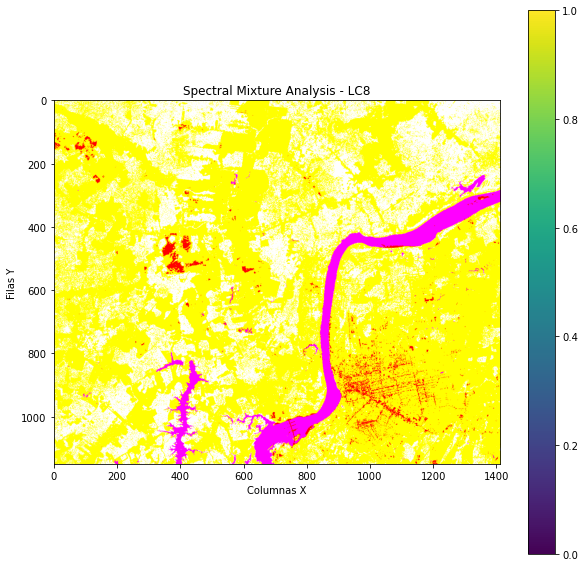

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(tct[:,:,0:3]) # magma, gray, etc.
plt.colorbar()
plt.title("Spectral Mixture Analysis - LC8") # Titulo
plt.xlabel('Columnas X') # Nombre del eje X
plt.ylabel('Filas Y') # Nombre del eje Y
plt.show()

- https://stackoverflow.com/questions/43331510/how-to-train-an-svm-classifier-on-a-satellite-image-using-python/43453194
- https://towardsdatascience.com/land-cover-classification-in-satellite-imagery-using-python-ae39dbf2929
- https://stackoverflow.com/questions/38710765/python-classs-attribute-not-in-init